In [1]:
import torch
import matplotlib.pyplot as plt
import os
import sys
import warnings
# module_path = os.path.abspath(os.path.join('TF_net'))
# if module_path not in sys.path:
#     sys.path.append(module_path)
from train import Dataset, train_epoch, eval_epoch, test_epoch, Scaler, preprocess
from args import parse_arguments
import torch.nn as nn
from torch.utils import data
from scipy import stats
from pathlib import Path
import numpy as np
from model_addon import LES

def describe(x, axis=None):
    return stats.describe(x, axis)

/home/lakshya/data/miniconda3/envs/tfnet/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
args = parse_arguments("")
args.data = 'data9_101.pt'


if args.data == "rbc_data.pt":
    compress = True
    permute = False
    offset=0
    transform_type = 'std'
    test_mode_train = False
elif args.data == 'data5.pt':
    compress = False
    permute = True
    offset = 60
    transform_type = 'std'
    split_spatially = False
elif 'data' in args.data and '101' in args.data:
    compress = False
    permute = True
    offset = 60
    transform_type = 'std'
    test_mode_train = True
else:
    raise ValueError("Un expected data file name")
args.transform = Scaler(transform_type, offset)


if Path(args.data).name == args.data: args.data = "../" + args.data #============================= extra line ========================================

data_prep = preprocess(args, permute, compress, test_mode=True)

tensor([-3.3224e-08])
tensor([2.3853]) <function Scaler.fit_transform.<locals>.<lambda> at 0x7fb730188ca0> <function Scaler.fit_transform.<locals>.<lambda> at 0x7fb730188ca0>


DescribeResult(nobs=1024, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)


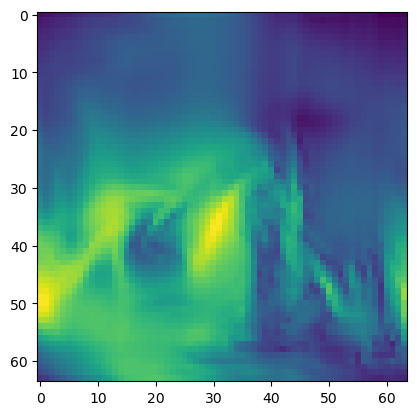

In [3]:
def plot_dft():
    idx=0
    signal = torch.linalg.norm(data_prep[idx], dim=0)
    fig, ax3 = plt.subplots(ncols=1)
    # ax1.imshow(signal)
    dft = torch.fft.fft2(signal)
    cutoff = int(0.5 * 64 )
    dft[cutoff:, cutoff:] = 0.0
    # ax2.imshow(torch.real(dft))
    idft = torch.fft.ifft2(dft)
    ax3.imshow(torch.real(idft))
    print(describe(torch.real(dft[32:,32:])))
    

plot_dft()

In [4]:
describe(data_prep)

DescribeResult(nobs=81420288, minmax=(-6.692568, 6.7363944), mean=-6.6121184e-09, variance=1.0000013235841525, skewness=0.0005446678606431011, kurtosis=0.6176786912699472)

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# d = 1, if using norm of velocity, else 2
def norm_each_sample(x, d=1):
    x = torch.clone(x)
    _max= torch.amax(x, dim=(d, d+1), keepdim=True) 
    _min= torch.amin(x, dim=(d, d+1), keepdim=True) 
    return (x - _min) / (_max - _min)

def plot(video, start=0, frames = None):
    print(video.shape)
    if frames is None:
        frames = video.shape[0]
    warnings.warn("Going to normalize each sample for visualizing purpose")
    video = norm_each_sample(video)
    fig = plt.figure() # figsize=(3,3)
    im = plt.imshow(video[start,:,:])

    plt.close() # this is required to not display the generated image

    def init():
        im.set_data(video[start,:,:])

    def animate(i):
        im.set_data(video[start+i,:,:])
        return im

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames,
                                interval=50)    #20 fps
    return anim.to_html5_video()

# HTML(plot(torch.linalg.norm(data_prep, dim=1), 1800, 120))

# Compare Predictions


In [6]:
def get_preds_trues(args, path, num_batches=1):
    print(f"Working on: {path}")
    test_indices = list(range(7700, 9800))
    input_length = args.input_length
    time_range = args.time_range
    batch_size = 21
    kernel_size = args.kernel_size
    dropout_rate = args.dropout_rate
    device = "cuda:"
    device_ids = [2]
    args.path = path
    args.pos_emb = args.pos_emb_dim > 0
    args.use_test_mode = not args.not_use_test_mode

    device = torch.device(f"cuda:{device_ids[0]}" if torch.cuda.is_available() else "cpu")

    model = LES(input_channels = input_length*2, output_channels = 2, kernel_size = kernel_size, dropout_rate = dropout_rate,
                time_range = time_range, addon_enc=args.addon_enc, addon_dec=args.addon_dec, time_emb_dim= args.pos_emb_dim).to(device)
    # Note: saved_model is already in eval model, 
    # this kind of trick is needed because the torch.save() stores the class file location.
    # So some models use model addon file others use model file. But model.py simply imports from model_addon.py only
    saved_model = torch.load(args.path+"model.pth", map_location=device).module
    model.load_state_dict(saved_model.state_dict())
    model.eval()    # If this is not used than saved_model and model inferences will be different

    loss_fun = torch.nn.MSELoss()
    best_model = nn.DataParallel(model, device_ids=device_ids)

    data_prep = preprocess(args, permute, compress, test_mode=args.use_test_mode)

    print("Testing in test setting")
    test_set = Dataset(test_indices, input_length + time_range - 1, 40, 60, data_prep, stack_x=True, test_mode=args.use_test_mode, test_mode_train=test_mode_train)
    test_loader = data.DataLoader(test_set, batch_size = batch_size, shuffle = False, num_workers = args.num_workers)
    preds, trues, loss_curve = test_epoch(args, test_loader, best_model, loss_fun,test_mode=not test_mode_train and args.use_test_mode, save_preds=True, device=device, \
                                        num_batches=num_batches)
    return preds, trues, loss_curve

In [15]:
from copy import deepcopy

def args_up1(args):
    args_copy = deepcopy(args)
    return args_copy, "../results/tfnet_data9_101/tfnet_data9_101_17/"

def args_up2(args):
    args_copy = deepcopy(args)
    return args_copy, "../results/lya_data9_101_coef2_1_m_learnt_0.4_s_150/lya_data9_101_coef2_1_m_learnt_0.4_s_150_17/"

compare = [args_up1, args_up2]
preds = []
trues = []
for cmp in compare:
    _1, _2, _ = get_preds_trues(*cmp(args))
    preds.append(_1)
    trues.append(_2)

preds = np.array(preds)
trues = np.array(trues)

for i in range(len(trues)-1):
    assert (trues[i] == trues[i+1]).all()

Working on: ../results/tfnet_data9_101/tfnet_data9_101_17/
tensor([-3.3224e-08])
tensor([2.3853]) <function Scaler.fit_transform.<locals>.<lambda> at 0x7fb6ea73aee0> <function Scaler.fit_transform.<locals>.<lambda> at 0x7fb6ea73aee0>
Testing in test setting


  1%|          | 1/100 [00:01<03:16,  1.98s/it]


[0.30779364 0.38554506 0.45474051 0.51849612 0.5781366  0.63747149
 0.69425669 0.74388896 0.78258041 0.81154396 0.8392958  0.87143555
 0.90828714 0.9461439  0.97465371 0.99524561 1.01034244 1.03081161
 1.06179242 1.10152901 1.14399661 1.1849797  1.21685257 1.23583583
 1.25184971 1.26668115 1.28235014 1.30611417 1.34308309 1.39387936
 1.44976115 1.49821842 1.53135708 1.55140572 1.5588116  1.55712658
 1.55895273 1.56167639 1.55873595 1.55326333 1.54795884 1.54681221
 1.54841883 1.54754939 1.54465236 1.54100058 1.53829856 1.53181176
 1.51868935 1.50211928 1.48799535 1.4789592  1.46832038 1.45458766
 1.44118568 1.43241477 1.42845413 1.4144295  1.39027464 1.36522483]
Working on: ../results/lya_data9_101_coef2_1_m_learnt_0.4_s_150/lya_data9_101_coef2_1_m_learnt_0.4_s_150_17/
tensor([-3.3224e-08])
tensor([2.3853]) <function Scaler.fit_transform.<locals>.<lambda> at 0x7fb6b42fb280> <function Scaler.fit_transform.<locals>.<lambda> at 0x7fb6b42fb280>
Testing in test setting


  1%|          | 1/100 [00:01<03:02,  1.85s/it]

[0.31250786 0.39056479 0.46350266 0.53183676 0.59737866 0.65952689
 0.71529381 0.75804226 0.78754626 0.80993214 0.82959005 0.85097863
 0.87684818 0.90403106 0.93022947 0.95091089 0.96897183 0.98774512
 1.00798625 1.03409822 1.06553707 1.099146   1.13454054 1.17144066
 1.212642   1.25903572 1.30563914 1.35207567 1.39716419 1.43967769
 1.4774539  1.51018687 1.54336001 1.57717172 1.59524536 1.59722295
 1.59458984 1.59078394 1.57983275 1.55751261 1.53303299 1.50871942
 1.48343312 1.46184151 1.44184897 1.42605689 1.41859581 1.42116892
 1.41976114 1.41036607 1.39386397 1.37270783 1.34910954 1.32646005
 1.30212851 1.28303733 1.28140794 1.29145077 1.29858385 1.29481932]


<bound method Artist.set_in_layout of <Figure size 1500x1500 with 3 Axes>>

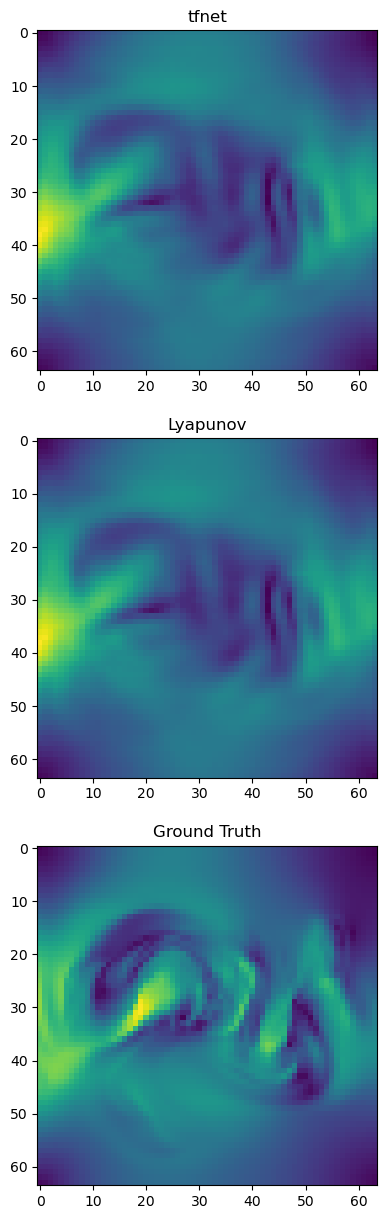

In [39]:
import matplotlib.pyplot as plt
time=30
batch_element=20
titles = ["tfnet", "Lyapunov"]
images=np.linalg.norm(preds[:, batch_element, time], axis=1)
fig, axs = plt.subplots(nrows=len(images)+1, figsize=(15,15))
for i, (img, titl) in enumerate(zip(images,titles)):
    axs[i].imshow(images[0]); axs[i].set_title(titl)
axs[-1].imshow(np.linalg.norm(trues[0, batch_element, time], axis=0)); axs[-1].set_title("Ground Truth")
fig.set_in_layout


In [13]:

fig = px.imshow(np.linalg.norm(preds[0][0,0], axis=0))
fig.show()

In [14]:
describe(np.linalg.norm(preds[0][0,0], axis=0))

DescribeResult(nobs=4096, minmax=(0.007351535, 2.5891514), mean=0.61668587, variance=0.22736306662087913, skewness=1.1952912046327437, kurtosis=1.066808564729036)

# Work with test predictions

In [8]:
test_indices = list(range(7700, 9800))
input_length = args.input_length
time_range = args.time_range
batch_size = 21
kernel_size = args.kernel_size
dropout_rate = args.dropout_rate
device = "cuda:"
device_ids = [2]
args.path = "../results/tfnet_data9_101/tfnet_data9_101_17/"
args.pos_emb = args.pos_emb_dim > 0
args.use_test_mode = not args.not_use_test_mode

device = torch.device(f"cuda:{device_ids[0]}" if torch.cuda.is_available() else "cpu")

model = LES(input_channels = input_length*2, output_channels = 2, kernel_size = kernel_size, dropout_rate = dropout_rate,
            time_range = time_range, addon_enc=args.addon_enc, addon_dec=args.addon_dec, time_emb_dim= args.pos_emb_dim).to(device)
# Note: saved_model is already in eval model, 
# this kind of trick is needed because the torch.save() stores the class file location.
# So some models use model addon file others use model file. But model.py simply imports from model_addon.py only
saved_model = torch.load(args.path+"model.pth", map_location=device).module
model.load_state_dict(saved_model.state_dict())
model.eval()    # If this is not used than saved_model and model inferences will be different

loss_fun = torch.nn.MSELoss()
best_model = nn.DataParallel(model, device_ids=device_ids)

data_prep = preprocess(args, permute, compress, test_mode=args.use_test_mode)

print("Testing in test setting")
test_set = Dataset(test_indices, input_length + time_range - 1, 40, 60, data_prep, stack_x=True, test_mode=args.use_test_mode, test_mode_train=test_mode_train)
test_loader = data.DataLoader(test_set, batch_size = batch_size, shuffle = False, num_workers = args.num_workers)
preds, trues, loss_curve = test_epoch(args, test_loader, best_model, loss_fun,test_mode=not test_mode_train and args.use_test_mode,device=device)

tensor([-3.3224e-08])
tensor([2.3853]) <function Scaler.fit_transform.<locals>.<lambda> at 0x7f2e57dc1ca0> <function Scaler.fit_transform.<locals>.<lambda> at 0x7f2e57dc1ca0>
Testing in test setting


100%|██████████| 100/100 [01:16<00:00,  1.30it/s]

[0.28502675 0.37668492 0.46453041 0.54781289 0.62564402 0.69682615
 0.76074402 0.81820188 0.869983   0.91590382 0.95566058 0.98952682
 1.01837509 1.04326873 1.06582872 1.08743009 1.1094729  1.1326509
 1.15626117 1.17900516 1.20070299 1.22152817 1.24070901 1.25823504
 1.27442298 1.28864086 1.30075922 1.31196491 1.32338493 1.33608662
 1.35099355 1.3675437  1.38462091 1.40234487 1.41980595 1.43627257
 1.45097921 1.46333382 1.47268122 1.47976994 1.48577928 1.49379492
 1.505259   1.51949875 1.53663576 1.55565811 1.57563168 1.59495348
 1.61208198 1.62589732 1.63639339 1.64512426 1.65336431 1.66114037
 1.67004444 1.68211701 1.6984443  1.71773497 1.73873528 1.75950888]


In [12]:
ndx = 52
ones = 0.1*np.ones_like(preds[ndx])
obs = np.concatenate((preds[ndx], ones, trues[ndx]),axis=2)
HTML(plot(torch.from_numpy(obs), 0))

In [17]:
HTML(plot(torch.from_numpy(preds[ndx]), 0))

In [21]:
print(stats.describe(preds, None))
print(stats.describe(trues, None))

(array([[ 0.,  0.,  7., ...,  0.,  0.,  0.],
        [ 0.,  0.,  7., ...,  0.,  0.,  0.],
        [ 0.,  0.,  7., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  9., 10., 11.],
        [ 0.,  0.,  0., ...,  9., 10., 11.],
        [ 0.,  0.,  0., ..., 10., 10., 11.]]),
 array([0.30961025, 0.30964309, 0.30967593, 0.3097088 , 0.30974165,
        0.30977449, 0.30980733, 0.30984017, 0.30987304, 0.30990589,
        0.30993873]),
 <a list of 448 BarContainer objects>)

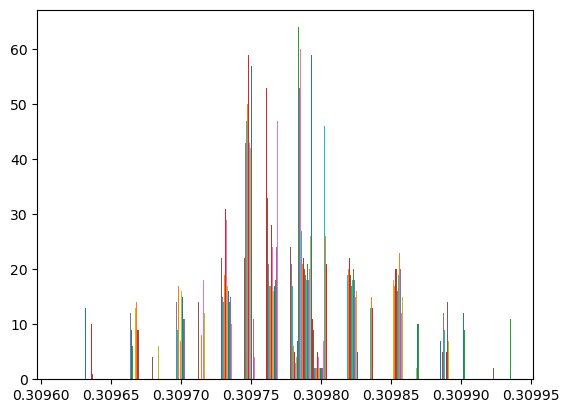

In [19]:
plt.hist(trues[ndx,0,0])